<a href="https://colab.research.google.com/github/nicoussj/MachineLearning/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [2]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Configuraciones para gráficos
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Ignorar advertencias
warnings.filterwarnings('ignore')



%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

##DataSet

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";", encoding='latin1', header=0)

df.columns = df.columns.str.replace(';', '')

df.head(10)

df = df.dropna()
df['RoundStartingEquipmentValue'] = df['RoundStartingEquipmentValue'].fillna(df['RoundStartingEquipmentValue'].median())
df = pd.get_dummies(df, columns=['Map'], drop_first=True)
#Cambio de datos: Cambiar de False4 en RoundWinner a False, agregar False a MatchWinner, ya que en contexto aplica
df.loc[29,'MatchWinner'] = 'False'
df.loc[29,'RoundWinner'] = 'False'
#Se eliminará columna Unnamed: 0, ya que solo contiene las ID de las filas
#Se eliminará AbnormalMatch, ya que contiene solamente valores False
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['AbnormalMatch'], inplace=True)

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022.csv


##Preparamos el Dataset

In [7]:
# Seleccionamos dos variables predictoras para el gráfico (por claridad visual)
features = ['TimeAlive', 'TravelledDistance']
target = 'MatchWinner'  # Puedes cambiar por Survived, RoundWinner, etc.

# Convertimos la variable objetivo a tipo categórico (si es necesario)
df[target] = df[target].astype(str)

# Clean and convert the features columns to numeric, handling 'nan' strings
for feature in features:
    df[feature] = df[feature].astype(str).str.replace('.', '', regex=False)
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Drop rows with NaN values introduced by the conversion
df.dropna(subset=features, inplace=True)

# Escalamos las variables para evitar que las diferencias de escala afecten el KNN
scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
y = df[target].values

##Creamos el Modelo

In [8]:
# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creamos y entrenamos el modelo KNN con pesos por distancia
from sklearn.neighbors import KNeighborsClassifier

k = 5  # Puedes ajustar este valor o calcularlo en el paso 5
model = KNeighborsClassifier(n_neighbors=k, weights='distance')
model.fit(X_train, y_train)


KNeighborsClassifier(weights='distance')

##Resultados Obtenidos

In [9]:
# Evaluamos el modelo con el conjunto de prueba
y_pred = model.predict(X_test)

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.54      0.56      0.55     12600
        True       0.48      0.47      0.48     11146

    accuracy                           0.52     23746
   macro avg       0.51      0.51      0.51     23746
weighted avg       0.52      0.52      0.52     23746

Matriz de Confusión:
[[7039 5561]
 [5910 5236]]


##Gráfica de la Clasificación Obtenida



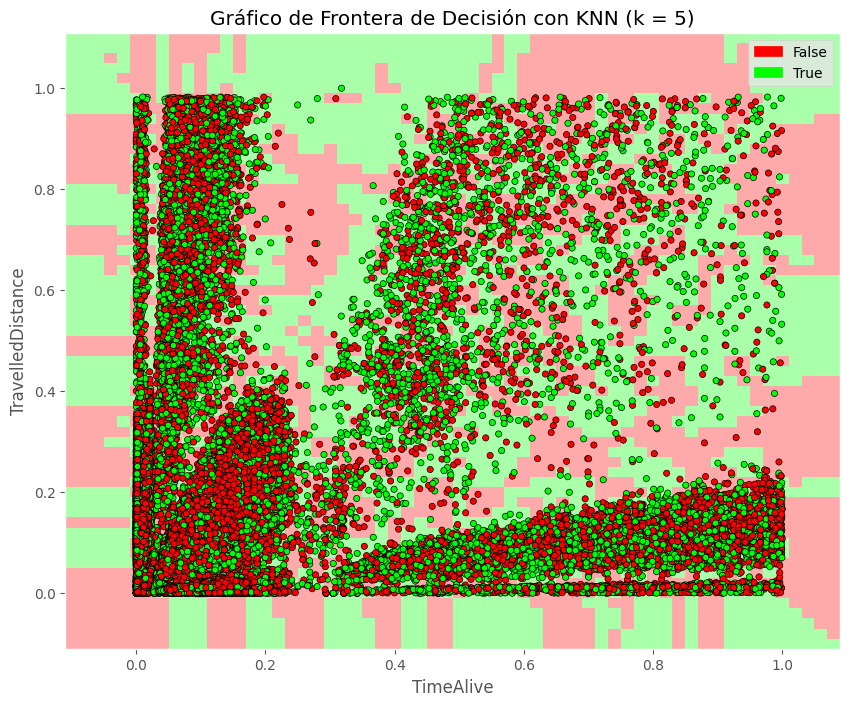

In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt

# Crear una malla para graficar las fronteras
h = .02  # tamaño del paso de la malla
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Convert the string predictions in Z to numerical values (0 for 'False', 1 for 'True')
Z = np.array([0 if label=='False' else 1 for label in Z.ravel()])
Z = Z.reshape(xx.shape)

# Colores para fondo y puntos
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Plot del gráfico
plt.figure(figsize=(10, 8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Puntos de entrenamiento
# Convertir las etiquetas de texto en y a valores numéricos (0 para 'False', 1 para 'True') para graficar
plt.scatter(X[:, 0], X[:, 1], c=[0 if label=='False' else 1 for label in y], cmap=cmap_bold, edgecolor='k', s=20)
plt.xlabel('TimeAlive')
plt.ylabel('TravelledDistance')
plt.title(f'Gráfico de Frontera de Decisión con KNN (k = {k})')

# Leyenda
patch0 = mpatches.Patch(color='#FF0000', label='False')
patch1 = mpatches.Patch(color='#00FF00', label='True')
plt.legend(handles=[patch0, patch1])
plt.show()

##Como obtener el valor de K

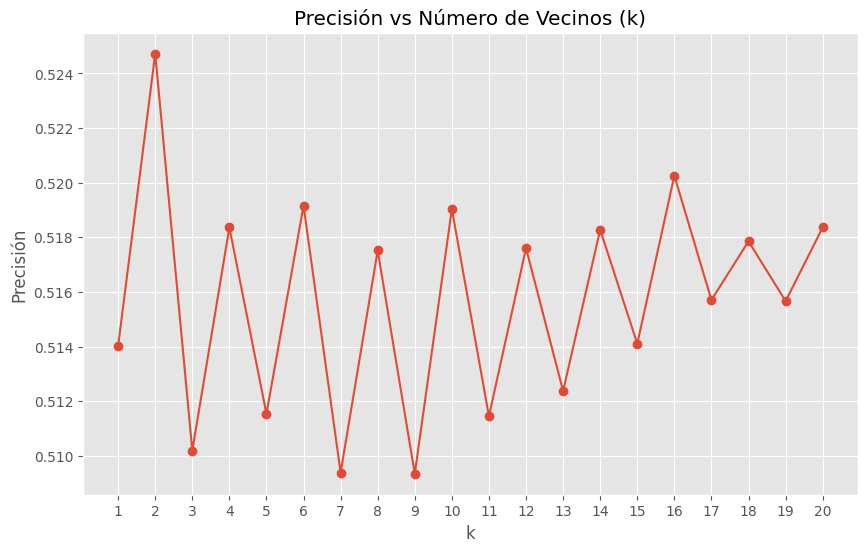

In [11]:
# Probar distintos valores de k y obtener su exactitud
from sklearn.metrics import accuracy_score

accuracies = []
k_range = range(1, 21)

for i in k_range:
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train, y_train)
    pred_i = knn_i.predict(X_test)
    accuracies.append(accuracy_score(y_test, pred_i))

# Graficar precisión vs. k
plt.figure(figsize=(10,6))
plt.plot(k_range, accuracies, marker='o')
plt.title("Precisión vs Número de Vecinos (k)")
plt.xlabel("k")
plt.ylabel("Precisión")
plt.xticks(k_range)
plt.grid(True)
plt.show()


##Realizar Predicciones

In [12]:
# Ejemplo: predecir clase para un nuevo jugador
nuevo = [[120, 1800]]  # TimeAlive, TravelledDistance
nuevo_esc = scaler.transform(nuevo)
prediccion = model.predict(nuevo_esc)
print(f"Predicción para el nuevo jugador: {prediccion[0]}")
if prediccion[0] == 'True':
    print("Predicción: Ganó la partida")
else:
    print("Predicción: No ganó la partida")


Predicción para el nuevo jugador: False
Predicción: No ganó la partida
